In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

# Familiar stack packages
import numpy as np
import glob
import anacal
import xlens
import fitsio
import lsst.afw.image as afwImage
import astropy.table as astTable
from astropy.visualization import ZScaleInterval
import fitsio

In [ ]:
cat1=fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/deepCoadd_anacal3/fields/hectomap.fits")
cat2=fitsio.read("/gpfs02/work/xiangchong.li/work/hsc_data/s23b/db_color/fields/hectomap.fits")

In [12]:
mag_g = 27-2.5* np.log10(cat1["g_flux"])
mag_r = 27-2.5* np.log10(cat1["r_flux"])
mag_i = 27-2.5* np.log10(cat1["i_flux"])
mag_z = 27-2.5* np.log10(cat1["z_flux"])
mag_y = 27-2.5* np.log10(cat1["y_flux"])

/tmp/ipykernel_2548/3921585222.py:1: RuntimeWarning: invalid value encountered in log10
  mag_g = 27-2.5* np.log10(cat1["g_flux"])
/tmp/ipykernel_2548/3921585222.py:2: RuntimeWarning: invalid value encountered in log10
  mag_r = 27-2.5* np.log10(cat1["r_flux"])
/tmp/ipykernel_2548/3921585222.py:3: RuntimeWarning: invalid value encountered in log10
  mag_i = 27-2.5* np.log10(cat1["i_flux"])
/tmp/ipykernel_2548/3921585222.py:4: RuntimeWarning: invalid value encountered in log10
  mag_z = 27-2.5* np.log10(cat1["z_flux"])
/tmp/ipykernel_2548/3921585222.py:5: RuntimeWarning: invalid value encountered in log10
  mag_y = 27-2.5* np.log10(cat1["y_flux"])


Text(0, 0.5, 'number')

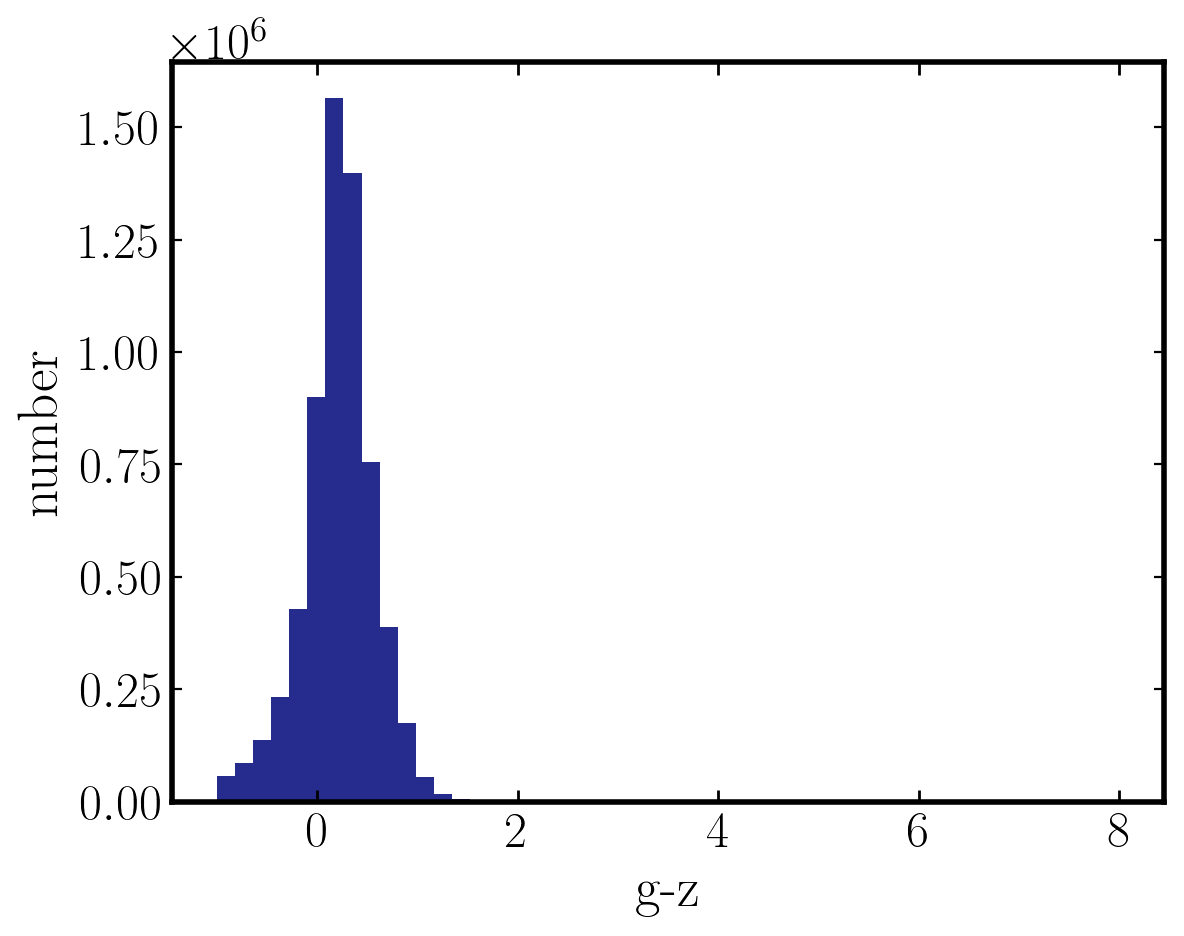

In [16]:
plt.hist(mag_i - mag_z, bins=50, range=(-1, 8))
plt.xlabel("g-z")
plt.ylabel("number")

In [ ]:
plt.hist(mag_g - mag_r, bins=50, range=(-1, 8))
plt.xlabel("g-z")
plt.ylabel("number")

In [5]:
msk = ((mag_g - mag_z) > 5) & ((mag_g - mag_z) < 7) & (mag_z < 19) & (mag_z > 18)
cat1 = cat1[msk]
cat2 = cat2[msk]

In [22]:
tp = np.int_(cat2["tract"]*1000.0) + np.int_(cat2["patch"])
mm2 = (tp == np.argmax(np.bincount(tp)))
cat1= cat1[mm2]
cat2= cat2[mm2]

In [24]:
cat2["tract"]

array([15820, 15820, 15820, 15820, 15820, 15820], dtype='>i2')

In [38]:
cat2.dtype.names

('object_id',
 'tract',
 'patch',
 'i_ra',
 'i_dec',
 'i_variance_value',
 'g_cmodel_mag',
 'g_cmodel_magerr',
 'g_cmodel_flag',
 'r_cmodel_mag',
 'r_cmodel_magerr',
 'r_cmodel_flag',
 'i_cmodel_mag',
 'i_cmodel_magerr',
 'i_cmodel_flag',
 'z_cmodel_mag',
 'z_cmodel_magerr',
 'z_cmodel_flag',
 'y_cmodel_mag',
 'y_cmodel_magerr',
 'y_cmodel_flag',
 'g_psfflux_mag',
 'g_psfflux_magerr',
 'r_psfflux_mag',
 'r_psfflux_magerr',
 'i_psfflux_mag',
 'i_psfflux_magerr',
 'z_psfflux_mag',
 'z_psfflux_magerr',
 'y_psfflux_mag',
 'y_psfflux_magerr',
 'a_g',
 'a_r',
 'a_i',
 'a_z',
 'a_y',
 'i_blendedness_abs',
 'i_hsmpsfmoments_shape11',
 'i_hsmpsfmoments_shape22',
 'i_hsmpsfmoments_shape12',
 'i_higherordermomentspsf_04',
 'i_higherordermomentspsf_13',
 'i_higherordermomentspsf_22',
 'i_higherordermomentspsf_31',
 'i_higherordermomentspsf_40')

In [25]:
cat2["patch"]

array([405, 405, 405, 405, 405, 405], dtype='>i2')

In [29]:
from lsst.skymap.ringsSkyMap import RingsSkyMap, RingsSkyMapConfig

ra = cat1["ra"]
dec = cat1["dec"]

# Set up the configuration
config = RingsSkyMapConfig()
config.numRings = 120
config.projection = "TAN"
config.tractOverlap = 1.0 / 60  # degrees
config.pixelScale = 0.168  # arcsec/pixel
skymap = RingsSkyMap(config)

In [ ]:
tract_id = 15820
patch_db = 405
patch_x = patch_db // 100
patch_y = patch_db % 100
patch_id = patch_x + patch_y * 9

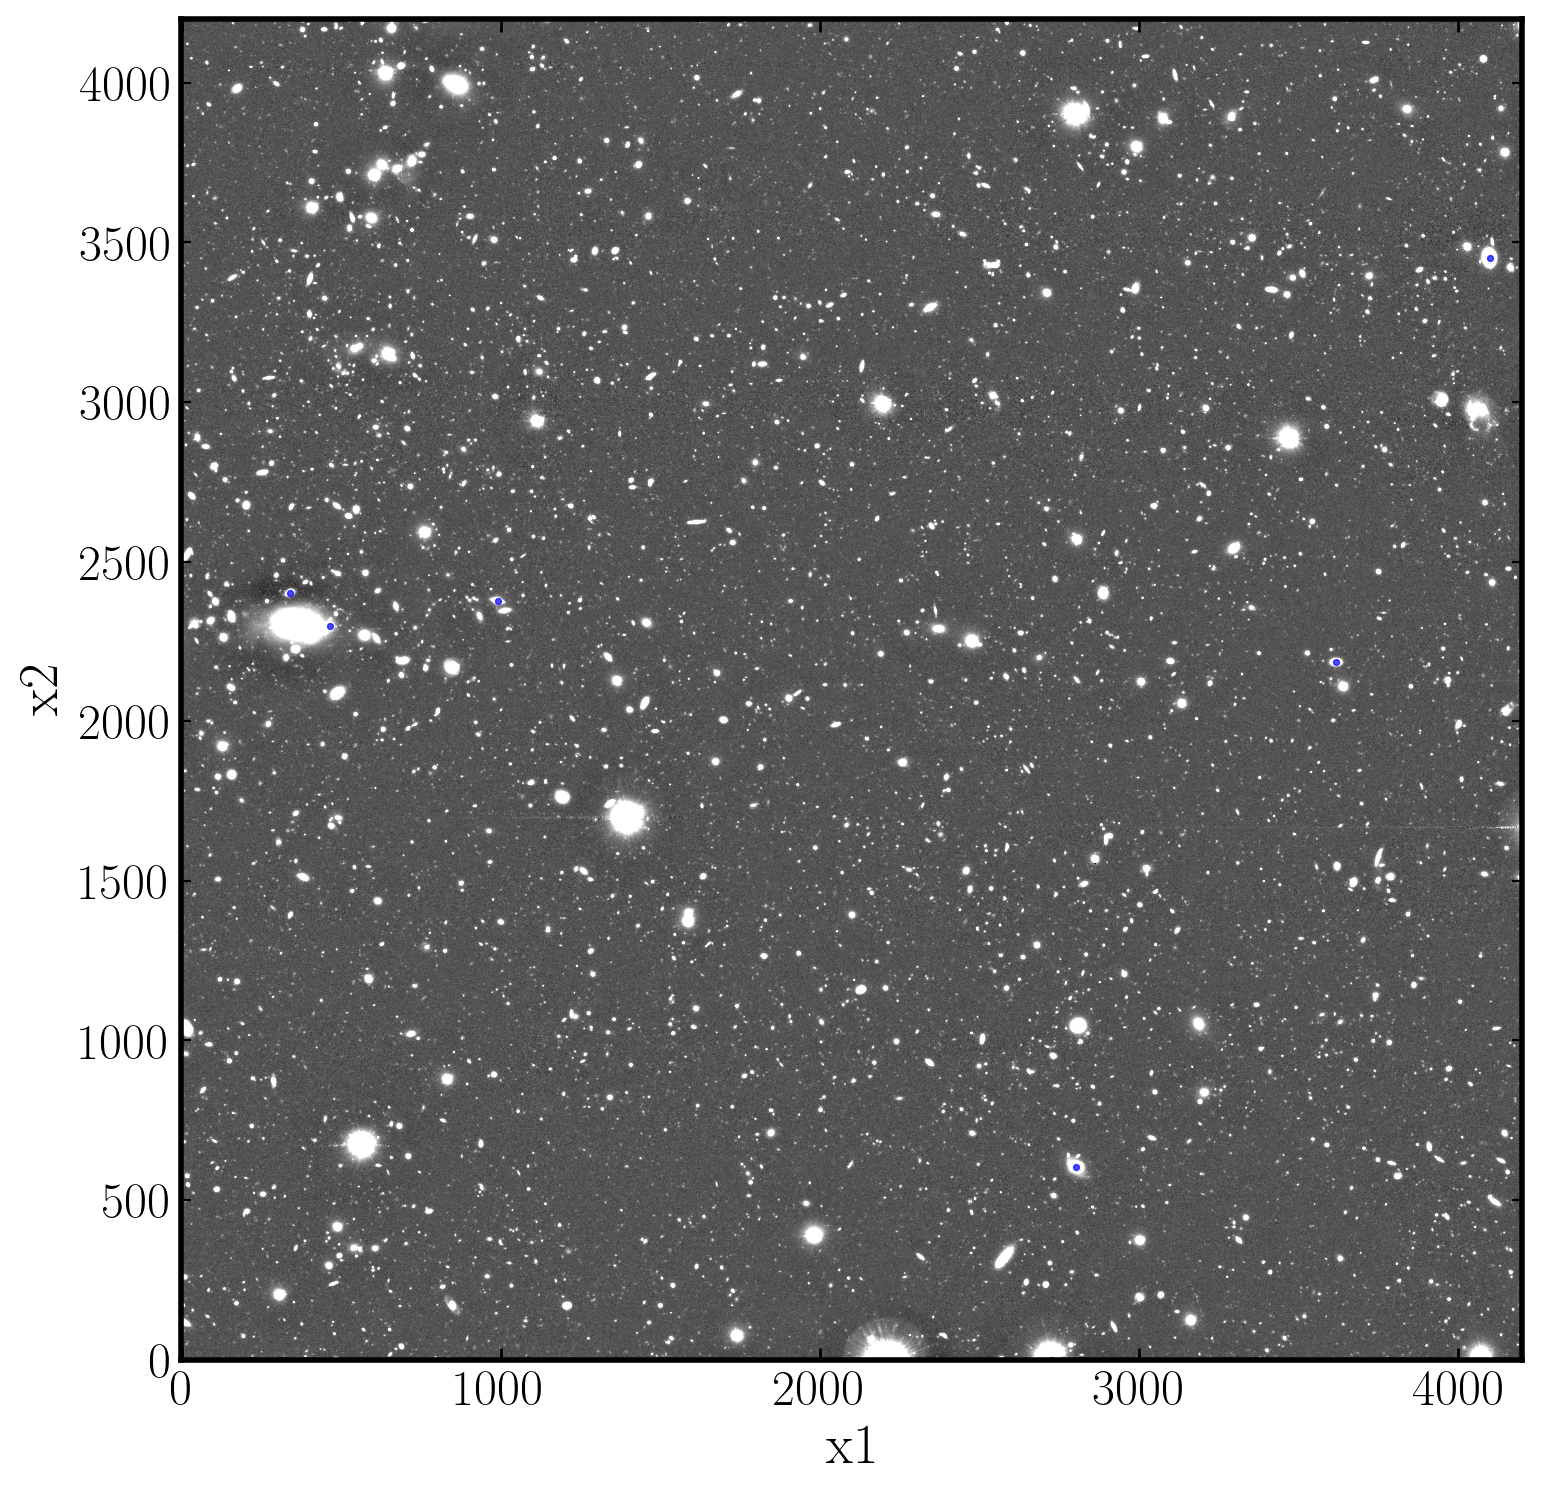

In [ ]:
def read_files(tract_id, patch_id):
    calexp_dir = f"{os.environ['s23b_calexp']}/{tract_id}/{patch_id}/i"
    exp_fname = glob.glob(os.path.join(calexp_dir, "*.fits"))[0]
    exposure = afwImage.ExposureF.readFits(exp_fname)
    mask_dir = f"{os.environ['s23b_mask']}/{tract_id}/{patch_id}"
    mask_fname = os.path.join(mask_dir, "mask2.fits")
    bmask = fitsio.read(mask_fname)
    nim_dir = f"{os.environ['s23b_nimg']}/{tract_id}/{patch_id}/i"
    nim_fname = glob.glob(os.path.join(nim_dir, "*.fits"))[0]
    bmask = (bmask | (fitsio.read(nim_fname) <=2).astype(np.int16))
    corr_fname = f"{os.environ['s23b_noisecorr']}/{tract_id}.fits"
    noise_corr = fitsio.read(corr_fname)
    return {
        "exposure": exposure,
        "mask": bmask,
        "noise_corr": noise_corr,
    }


patch_info = skymap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()
res = read_files(tract_id, patch_id)

bb = res["exposure"].getWcs()
x, y = wcs.skyToPixelArray(
    ra=ra, 
    dec=dec,
    degrees=True,
)
bb = res["exposure"].getBBox()
mm = (x > bb.getBeginX()) & (y> bb.getBeginY()) & (x < bb.getEndX()) & (y< bb.getEndY())
x = x[mm] - bb.getBeginX()
y = y[mm] - bb.getBeginY()
plt.close()
image = res["exposure"].image.array
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x, y, s=4.5, c='blue', edgecolors='blue', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()

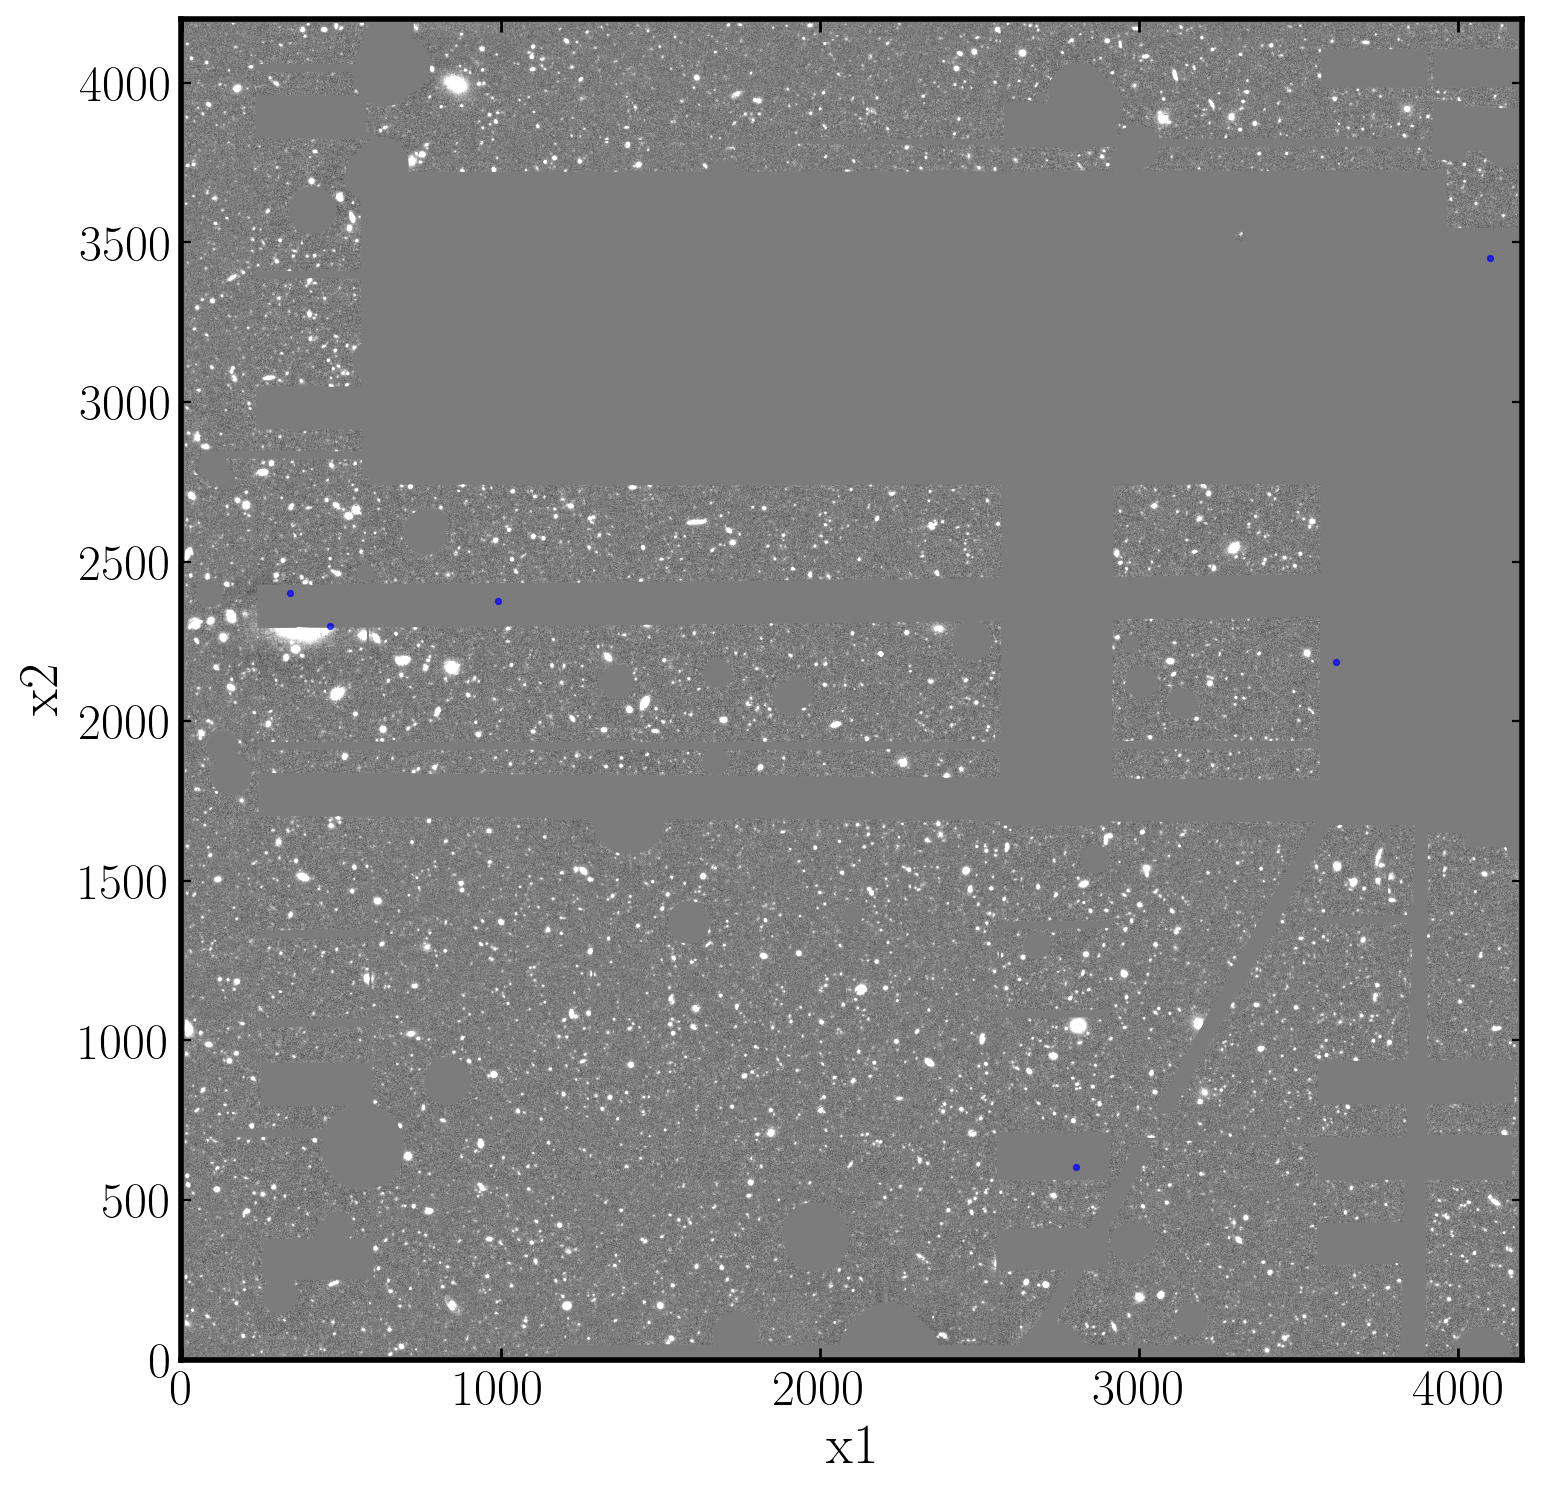

In [37]:
def read_files(tract_id, patch_id):
    calexp_dir = f"{os.environ['s23b_calexp']}/{tract_id}/{patch_id}/g"
    exp_fname = glob.glob(os.path.join(calexp_dir, "*.fits"))[0]
    exposure = afwImage.ExposureF.readFits(exp_fname)
    mask_dir = f"{os.environ['s23b_mask']}/{tract_id}/{patch_id}"
    mask_fname = os.path.join(mask_dir, "mask2.fits")
    bmask = fitsio.read(mask_fname)
    nim_dir = f"{os.environ['s23b_nimg']}/{tract_id}/{patch_id}/g"
    nim_fname = glob.glob(os.path.join(nim_dir, "*.fits"))[0]
    bmask = (bmask | (fitsio.read(nim_fname) <=2).astype(np.int16))
    corr_fname = f"{os.environ['s23b_noisecorr']}/{tract_id}.fits"
    noise_corr = fitsio.read(corr_fname)
    return {
        "exposure": exposure,
        "mask": bmask,
        "noise_corr": noise_corr,
    }


patch_info = skymap[tract_id][patch_id]
wcs = patch_info.getWcs()
bbox = patch_info.getOuterBBox()
res = read_files(tract_id, patch_id)

bb = res["exposure"].getWcs()
x, y = wcs.skyToPixelArray(
    ra=ra, 
    dec=dec,
    degrees=True,
)
bb = res["exposure"].getBBox()
mm = (x > bb.getBeginX()) & (y> bb.getBeginY()) & (x < bb.getEndX()) & (y< bb.getEndY())
x = x[mm] - bb.getBeginX()
y = y[mm] - bb.getBeginY()

plt.close()
image = res["exposure"].image.array * (1.0 - res["mask"])
# Use ZScale for a good display stretch (common in astronomy)
interval = ZScaleInterval()
vmin, vmax = interval.get_limits(image)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(image, origin='lower', cmap='gray', vmin=vmin, vmax=vmax)
ax.scatter(x, y, s=4.5, c='blue', edgecolors='blue', linewidths=0.5, alpha=0.7)

ax.set_xlabel("x1")
ax.set_ylabel("x2")

plt.tight_layout()
plt.show()